In [1]:
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import json
from pathlib import Path

In [2]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)

In [36]:
labelsize=10
markersize=4
linewidth = 0.75

def column_display_name(col):
    d = {
        "errorrate": "Uniform error rate",
        "divergence": "Divergence",
        "runtime": "Runtime per alignment [s]",
        "runtime_capped": "Runtime per alignment [s]",
        "s_per_pair": "Avg. runtime per alignment [s]",
        "s_per_pair_capped": "Avg. runtime per alignment [s]",
        "length": "Sequence length [bp]",
        # from A*PA
        "ed": "Edit distance",
        "expanded": "Expanded states",
        "explored": "Explored states",
        "band": "Equivalent band",
        "ord": "Sequence pair",
        "algo_key": "algorithm",
        "algo_pretty": " ",
        "job_costs_open": "Gap open cost",
        "job_costs_sub": "Substitution cost",
        "job_costs_extend": "Gap extend cost",
    }
    if col in d:
        return d[col]
    return col

dataset_pretty = {'ont-ul-500k': 'ONT read errors', 'ont-minion-ul-500k': 'Biological mutations'}
dataset_order = list(dataset_pretty.keys())

r_to_marker = {
    0: 'o',
    1: 'o', #'^', or 'D'
    2: 'o', #'v', or 's'
}
def r_marker(row):
    r = row['r']
    return r_to_marker.get(r, 'o')


# Line style:
# - slow (no pruning): dotted
# - normal: solid
# - diagonal-transition: dashed
# Colours:
# edlib/wfa ('extern'): blue/purple
# sh/csh/gcsh: orange -> brown -> green gradient
# noprune/normal/dt: 60% -> 70% -> 85% saturation
colors = {'dijkstra': '#786061', 'sh': "#e87146", 'csh': "#8c662a", 'gcsh': "#257d26"}
dashed = (0, (5, 5))
dotted = (0, (1, 4))
algorithm_styles = {
    "edlib": ("#DE4AFF", 'o', dashed, 'Edlib'),
    "wfa": ("#625AFF", 'o', '-', 'WFA'),
    "biwfa": ("#625AFF", 'o', '-', 'BiWFA'),
    "dijkstra": (colors['dijkstra'], 'o', dashed, 'Dijkstra'),
    "sh-noprune": (colors['sh'], r_marker, dotted, 'SH (no prune)'),
    "csh-noprune": (colors['csh'], r_marker, dotted, 'CSH (no prune)'),
    "gcsh-noprune": (colors['gcsh'], r_marker, dotted, 'GCSH (no prune)'),
    "sh": (colors['sh'], r_marker, dashed, 'SH'),
    "csh": (colors['csh'], r_marker, dashed, 'CSH'),
    "gcsh": (colors['gcsh'], r_marker, dashed, 'GCSH'),
    "dijkstra-dt": (colors['dijkstra'], 'o', '-', 'Dijkstra+DT'),
    "sh-dt": ('#e35522', r_marker, '-', 'SH+DT'),
    "csh-dt": ('#875a12', r_marker, '-', 'CSH+DT'),
    "gcsh-dt": ('#0f7a10', r_marker, '-', 'GCSH+DT'),
    'astarpa': ('#0f7a10', r_marker, '-', 'GCSH+DT'),
    "unknown": ("black", 'o', '-', 'Unknown'),
}
algorithm_order = list(algorithm_styles.keys())
palette = {k: v[0] for k, v in algorithm_styles.items()}

def get_algorithm_key(row):
    name = row['algo_name']
    if name == 'Edlib': return 'edlib'
    if name == 'Wfa':
        if row['job_algo_Wfa_memorymodel'] == 'MemoryUltraLow':
            return 'biwfa'
        else:
            return 'wfa'
    if name == 'AstarPA':
        t = row['job_algo_AstarPA_heuristic_type']
        r = row['job_algo_AstarPA_heuristic_type']
        dt = row['job_algo_AstarPA_diagonaltransition']
        prune = row['job_algo_AstarPA_heuristic_prune'] if 'job_algo_AstarPA_heuristic_prune' in row else 'Both'
        if t == 'None':
            key = 'dijkstra'
        else:
            key = t.lower()
        if t != 'None' and prune == 'None':
            key += '-noprune'
        if dt:
            key += '-dt'
        return key
    return 'unknown'

# Returns display name, color, and style for an algorithm
def algorithm_display(row, split='unknown'):
    key = row['algo_key']
    (c, s, l, n) = algorithm_styles.get(key, (np.random.rand(3), 'o', '-', split))
    if callable(s): s = s(row)
    if 'r' in split:
        r = row.r
        if r:
            n += f' (r={r})'
    return (c, s, l, n)

In [4]:
def read_results(path):
    # - Read a json file
    # - Rename json fields from a_b to a-b
    # - Flatten into dataframe
    # - Flatten algorithm params into a few fields:
    #   - algo_name: the type of algorithm
    #   - algo_full: the json-string of algorithm parameters
    #   - algo_json: the json-object of algorithm parameters
    # - Rename and compute some common columns:
    #   - error-rate
    #   - length
    #   - s_per_pair
    #   - p_correct
    
    json_path = Path(path)
    data = json.loads(json_path.read_text())
    
    # Remove underscores from all keys
    def remove_underscores(o):
        if isinstance(o, list):
            return [remove_underscores(v) for v in o]
        if isinstance(o, dict):
            return {k.replace('_', ''): remove_underscores(v) for k, v in o.items()}
        return o
    
    data = remove_underscores(data)
            

    # Clean up algo columns
    for x in data:
        name = list(x['job']['algo'].keys())[0]
        obj = x['job']['algo']
        obj['name'] = name
        x['algo_name'] = name
        x['algo_full'] = json.dumps(obj)
        #del x['job']['algo']
        if 'Ok' in x['output']:
            del x['output']['Ok']['costs']

    # Flatten the js
    df = pd.json_normalize(data, sep='_')
    df['algo_json'] = df.algo_full.map(lambda x: json.loads(x))
    df['algo_key'] = df.apply(get_algorithm_key, axis=1)
    df['algo_pretty'] = df['algo_key'].map(lambda key: algorithm_styles[key][3])
    
    # Order by algo_key
    df['algo_ord'] = df['algo_key'].map(lambda key: algorithm_order.index(key))
    df.sort_values(by='algo_ord', inplace=True)
    # Order by dataset
    if 'job_dataset_File' in df.columns:
        df['dataset'] = df['job_dataset_File'].map(lambda f: Path(f).parent.name)
        df['dataset_ord'] = df['dataset'].map(lambda key: dataset_order.index(key))
        df.sort_values(by='dataset_ord', inplace=True, kind = 'stable')
    
    # Convenience renaming
    df = df.rename({'job_dataset_Generated_length': 'length',
                    'job_dataset_Generated_errorrate': 'errorrate',
                    'job_timelimit': 'timelimit',
                    'output_Ok_pcorrect': 'pcorrect',
                    'output_Ok_measured_runtime': 'runtime',
                    'output_Ok_measured_memory': 'memory',
                    'stats_divergence_mean': 'divergence',
                    'job_algo_AstarPA_diagonaltransition': 'dt',
                    'job_algo_AstarPA_heuristic_prune': 'prune',
                    'job_algo_AstarPA_heuristic_r': 'r'}, axis='columns')
    
    # Computed columns
    df['costmodel'] = df.apply(lambda row: (row['job_costs_sub'], row['job_costs_open'], row['job_costs_extend']), axis=1)
    df['s_per_pair'] = df['runtime'] / df['stats_seqpairs']
    df['timelimit_per_pair'] = df['timelimit'] / df['stats_seqpairs']
    #df['runtime_capped'] = df[['runtime', 'timelimit']].min(axis=1)

    def runtime_capped(row):
        if not math.isnan(row['runtime']):
            return row['runtime']
        if row['output_Err'] == 'Timeout':
            return row['timelimit']
        return row['timelimit']*1.1
    df['runtime_capped'] = df.apply(runtime_capped, axis = 1)
    df['s_per_pair_capped'] = df['runtime_capped'] / df['stats_seqpairs']
    
    df['editdistance'] = df['stats_insertions'] + df['stats_deletions'] + df['stats_substitutions']
    
    # Some specific fixes
    df = df.fillna({'r': 0}, downcast='infer')
    
    # Remove unsupported algos
    if 'output_Err' in df.columns:
        df = df[df.output_Err != 'Unsupported']
    
    return df

In [5]:
# Updates algo_full to the string representation of only non-constant columns
def filter_algo_columns(df):
    algo_df = pd.json_normalize(df.algo_json, sep='_')
    fixed = []
    variable = []
    def shortname(col):
        if '_' in col:
            return col[col.rindex('_')+1:]
        else:
            return col
    for col in algo_df.columns:
        vals = algo_df[col].astype('str')
        val = vals.iloc[0]
        all_same = vals.eq(val).all()
        if all_same:
            if val != 'nan' and val != 'None':
                fixed.append((shortname(col), val))
            algo_df = algo_df.drop(columns=col)
        else:
            variable.append(shortname(col))
    for col in ['length', 'errorrate', 'job_costs_sub', 'job_costs_open', 'job_costs_extend', 'job_dataset_Generated_errormodel']:
        if not col in df: continue
        vals = df[col].astype('str')
        val = vals.iloc[0]
        all_same = vals.eq(val).all()
        if all_same:
            if val != 'nan' and val != 'None':
                fixed.append((shortname(col), val))
        
    merged = '/'.join(variable)
    algo_df = algo_df.rename(shortname, axis='columns')
    algo_df = {k: '/'.join("-" if isinstance(vv, float) and math.isnan(vv) else str(vv) for kk, vv in v.items()) for k, v in algo_df.to_dict('index').items()}
    df[merged] = algo_df
    return (fixed, df, merged)

In [6]:
def plot(df,
         name='',
         file=None,
         x='length',
         y='s_per_pair',
         # Column to use for hue and style.
         # Always change both at the same time!
         hue='algo_json',
         style='algo_json',
         # column to use for marker size
         size=None,
         # Logarithmic axes by default
         xlog=True,
         ylog=True,
         ylim=None,
         # alph
         alpha=1.0,
         # Use line instead of scatter plot?
         connect=False,
         # Draw a cone from the given filter and x
         cone=None,
         cone_x=3*10**4,
         legend='auto',
         fit=False,
         line_labels=False,
         categorical=False,
         dodge=False,
         ax=None,
         subtitle=True,
         width=None,
         height=None,
        ):
    
    if df[y].isna().all():
        print(f"All values of {y} are nan.")
        return
    
    df = df[df[y].notnull()]
    
    if df.empty: return
    
    # Copy columns so we can add new columns to sliced data.
    df = df.copy().reset_index()
    (fixed, df, split_col) = filter_algo_columns(df)
    fixed = ' '.join(f'{x}={y}' for (x,y) in fixed)
    if hue == 'algo_json':
        hue = split_col
    if style == 'algo_json':
        style = split_col
    split = [hue, style]
    if 'r' in split and 'r' in df.columns:
        if not (1 in df.r.values and 2 in df.r.values):
            split.remove('r')
    
    groups = df.groupby(split, sort=False)
    
    
    sns.reset_defaults()
    sns.set_context(None) # 'paper', 'notebook'
    
    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(width if width else 3, height if height else 2, forward=True)
        hasax = False
    else:
        hasax = True

    
    # Set log scales
    ax.set(xscale='log' if xlog else 'linear', yscale='log' if ylog else 'linear')
    
    # limit number of ticks
    if ylog:
        ax.locator_params(axis='y', numticks=6)
    else:
        ax.locator_params(axis='y', nbins=6)
    
    
    # PLOTTING
    
    args = {
        'data': df,
        'x': x,
        'y': y,
        'hue': hue,
        'palette': palette if hue == 'algo_key' else None,
        'style': style,
        'markers': r_to_marker if style == 'r' else True,
        'size': size,
        'legend': legend,
        'alpha': alpha,
        'ax': ax,
        'zorder': 4
    }
    
    if not categorical:
        for k, group in groups:
            first_row = group.iloc[0]
            color, style, linestyle, grouplabel = algorithm_display(first_row, split)
            fit_label = grouplabel

            ax.plot(x,
                    y,
                    data=group.sort_values(by=x),
                    color=color,
                    linestyle=linestyle if connect else 'None',
                    marker=style,
                    alpha=alpha,
                    dash_capstyle = 'round',
                    label=grouplabel,
                    zorder=2,
                    markersize=markersize,
                    linewidth=linewidth
                    #legend=legend,
                   )
    if categorical:
        order=None
        sns.swarmplot(data=df,
                        x=x,
                        y=y,
                        hue=hue,
                        palette= palette if hue == 'algo_key' else None,
                        ax=ax,
                        size=3,
                        linewidth=0,
                        edgecolor='gray',
                        order=order,
                        zorder=4,
                        #native_scale=True,
                        dodge=dodge,
        )
        sns.boxplot(data=df,
                    x=x,
                    y=y,
                    zorder=3,
                    ax=ax,
                    boxprops={'facecolor':'None'},
                    order=order,
                    showfliers=False,
                    linewidth=linewidth,
                   )
    
    # TEXT
    
    # Title
    if name:
        if not subtitle:
            ax.set_title(name, y=1.05)
        else:
            ax.set_title(f"{name}\n{fixed}", y=1.05)
    
    # Legend
    if legend and not categorical:
        ax.legend(
            markerscale=2 if size is None else None,
            handlelength=0.6,
            handletextpad=0.3,
            frameon=True,
            labelspacing=0.3,
        )
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    if categorical:
        ax.legend().remove()
    
    # BACKGROUND
    ax.set_facecolor("#F8F8F8")
    ax.grid(False)
    ax.grid(True, axis="y", which="major", color="w")
    
    
    # AXES
    
    # Labels
    ax.set_xlabel(column_display_name(x))  # weight='bold',
    ax.set_ylabel(column_display_name(y), rotation=0, ha="left")
    ax.yaxis.set_label_coords(-0.10, 1.00)
    
    # Limits
    x_margin = 1.5
    y_margin = 3
    if xlog:
        #xs = df[df[x] > 0][x]
        ax.set_xlim(df[x].min() / x_margin, df[x].max() * x_margin)

    if ylog:
        ax.set_ylim(df[y].min() / y_margin, df[y].max() * y_margin)
    
    # Start linear scales at 0.
    if not xlog and not categorical and x != 'job_costs_open':
        ax.set(xlim=(0,None))
    if not ylog:
        ax.set(ylim=(0,None))
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
 
    
    # Show bottom spine, and left spine when xlog=false
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(not xlog and not categorical)
    
    # Format % scales.
    if x in ['errorrate', 'divergence']:
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    
    # Show major ticks
    ax.tick_params(
        axis="both",
        which="major",
        bottom=True,
        top=False,
        left=True,
        right=False,
    )
    # No minor ticks
    ax.tick_params(
        axis="both",
        which="minor",
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,  # labels along the bottom edge are off
    )
    # Do show minor ticks for small log ranges
    if ylog:
         ax.tick_params(axis="y", which="minor", left=True)
    
    
    # CONE
    # Fills the region between x**1 and x**2
    if cone:
        x0 = cone_x
        x_max = x_margin * df[x].max()
        x_range = (x0, x_max)
        
        y0 = df[cone(df) & (df[x] == cone_x)][y].max()
        y_lin = (y0, y0 * (x_max / x0) ** 1)
        y_quad = (y0, y0 * (x_max / x0) ** 2)
        ax.fill_between(x_range, y_lin, y_quad, color="grey", alpha=0.15)
        
    # TIME LIMIT
    if y=='runtime_capped' or (y=='s_per_pair_capped' and x != 'length'):
        timelimit = df.timelimit.iloc[0]
        # FIXME: ENABLE THIS ASSERT AGAIN
        #assert df[df.runtime.isna()].timelimit.eq(timelimit).all()
        # Draw a red line at the timelimit.
        ax.axhline(y=timelimit, color="red", linestyle="-", alpha=1, linewidth=0.5)
        
        # Modify/add the timelimit ticklabel with TL=
        #fig.canvas.draw()
        ylabels = [x for x in ax.get_yticklabels()]
        found = False
        for i, l in enumerate(ylabels):
            if l.get_position()[1] == timelimit:
                ylabels[i] = "TL=" + ylabels[i].get_text()
                found = True
        if found:
            ax.set_yticklabels(ylabels)
        else:
            yticks = list(ax.get_yticks())
            ylabels = list(ax.get_yticklabels())
            yticks.append(timelimit)
            ylabels.append("TLE")
            ax.set_yticks(yticks)
            try:
                ax.set_yticklabels(ylabels)
            except ValueError:
                pass
            finally:
                pass
    
    if y=='s_per_pair_capped' and x=='length':
        assert xlog and ylog, "Plotting capped per-pair-runtimes with x==length only work in log-log plots"
        xmin = df[x].min()
        xmax = df[x].max()
        # Make groups base on total_size
        for total_size, group in df.groupby(by='job_dataset_Generated_totalsize'):
            ymin = group[group[x]==xmin]['timelimit_per_pair'].iloc[0]
            ymax = group[group[x]==xmax]['timelimit_per_pair'].iloc[0]
            plt.axline((xmin,ymin), (xmax,ymax), color="red", linestyle="-", alpha=1, linewidth=0.5)
            
    # POLY FIT

    def angle(slope):
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        bbox = ax.get_window_extent()
        x_sz = bbox.width
        y_sz = bbox.height
        x_factor = x_sz / (np.log10(x_max) - np.log10(x_min) if xlog else x_max - x_min)
        y_factor = y_sz / (np.log10(y_max) - np.log10(y_min) if ylog else y_max - y_min) 
        slope = slope * y_factor / x_factor
        return math.atan(slope)*180/math.pi
    
    def offset(row):
        return 1/10 if first_row['dt'] == True else 2.5
    
    if fit:
        assert x=='length' and xlog and ylog, "Polynomial fits only work in log-log plots with x=length"
        for k, group in groups:
            first_row = group.iloc[0]
            color, style, linestyle, grouplabel = algorithm_display(first_row, split)
            fit_label = grouplabel
            
            filtered = group[group.runtime.notnull()]
            ps = filtered[[x,y]].dropna()
            xmin, xmax = filtered[x].min(), filtered[x].max()
            if len(ps) > 1:
                fit = np.polyfit(np.log(ps[x]), np.log(ps[y]), 1)
                f = lambda x: x**fit[0] * np.exp(fit[1])
                # Extra {{ and }} are for the math-mode superscript
                fit_label = f"{grouplabel} $\sim n^{{{fit[0]:0.2f}}}$"

                ymin, ymax = f(xmin), f(xmax)
                # line from xmin to xmax (use plt.axline for infinite line)
                ax.plot([xmin, xmax], [ymin, ymax], color=color, linestyle=linestyle, alpha=1, dash_capstyle = 'round', label=grouplabel, zorder=2, linewidth=linewidth)
                #print(f'Exponent for {k}: {fit[0]:0.2f}')

            ax.text(
                xmax,
                min(ymax, ax.get_ylim()[1]), #*offset(first_row),
                fit_label,
                color=color,
                ha="right",
                va="bottom",
                size=labelsize,
                alpha=1,
                rotation=angle(fit[0]),
                rotation_mode='anchor',
            )
    if line_labels:
        # If no legend and no fits are shown, show manual labels instead
        for split_key, group in groups:
            first_row = group.iloc[0]
            color, style, linestyle, grouplabel = algorithm_display(first_row, split)
            max_idx = group[x].idxmax()
            label_x = group[x][max_idx]
            label_y = min(group[y][max_idx], ax.get_ylim()[1])
            key = split_key[0] if isinstance(split_key, tuple) else split_key
            
            by_x = group[x].argsort()
            last = group.iloc[by_x.iloc[-1]]
            before = group.iloc[by_x.iloc[-3]]
            slope = (last[y] - before[y])/(last[x] - before[x])
            ax.text(
                label_x,
                label_y,
                grouplabel,
                color=color,
                ha="right",
                va="bottom",
                size=labelsize,
                alpha=1,
                rotation=angle(slope),
                rotation_mode='anchor',
            )

    if not hasax:
        if file:
            plt.savefig(f"plots/{file}.pdf", dpi=300, bbox_inches='tight')
            plt.savefig(f"plots/{file}.png", dpi=300, bbox_inches='tight')
        return ax

def plot_all(df, name, x='length', size='errorrate', alpha=1.0):
    # p_correct
    plot(df[df.job_traceback == False], x=x, y='pcorrect', alpha=alpha, size=size, name=f'{name} proportion correct', ylog=False)
    # cost
    plot(df[df.job_traceback == False], x=x, y='s_per_pair_capped', size=size, alpha=alpha, name=f'{name} cost')
    # trace
    plot(df[df.job_traceback == True], x=x, y='s_per_pair_capped', size=size, alpha=alpha, name=f'{name} traceback')


# Aligner comparison

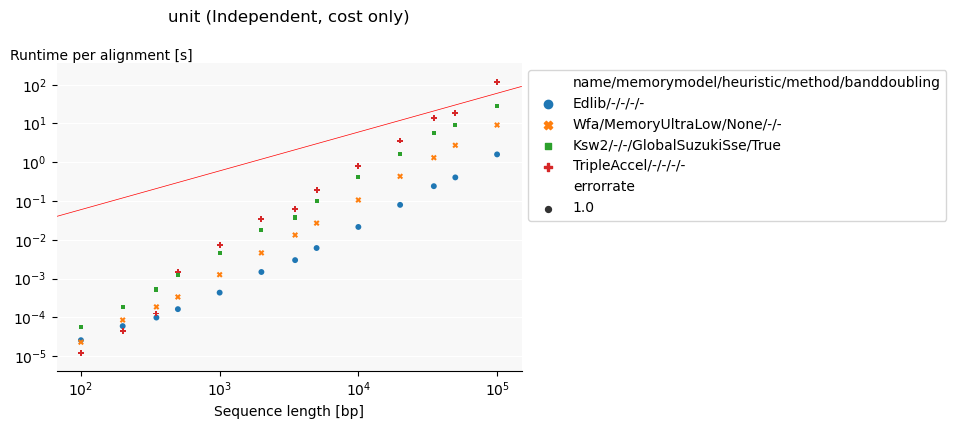

In [72]:
df = read_results("../results/unit.json")
#df = df[df.job_dataset_Generated_errormodel == 'Uniform']

df = df[df.job_traceback == True]
for k, g in df.groupby('job_dataset_Generated_errormodel'):
    if k == 'Independent':
        plot(g, x='length', y='s_per_pair_capped', size='errorrate', name=f'unit ({k}, cost only)')
    #plot(g, x='errorrate', y='s_per_pair_capped', size='length', name=f'unit ({k}, cost only)', xlog=True)

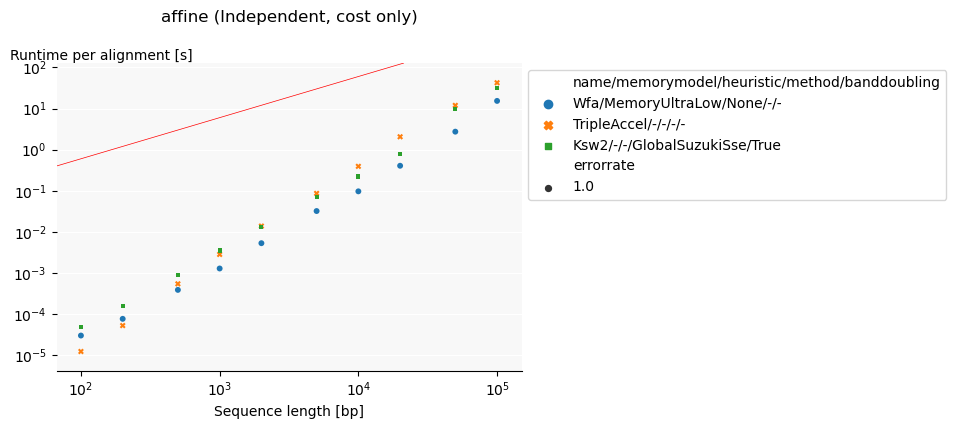

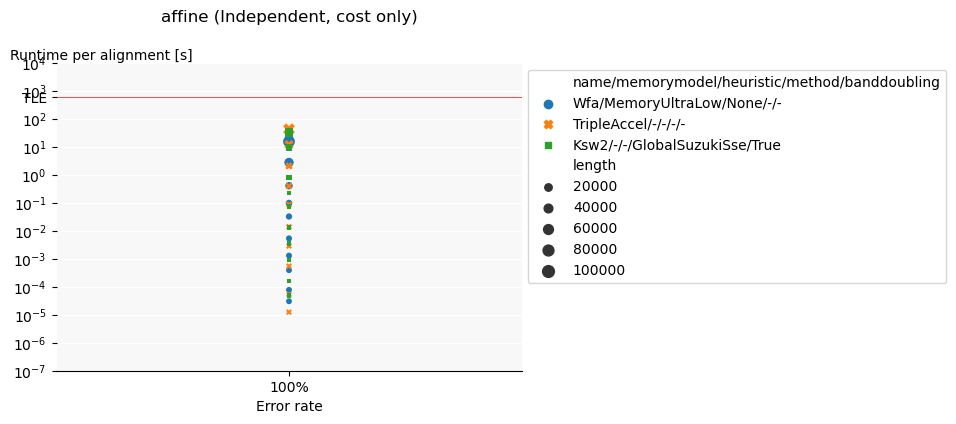

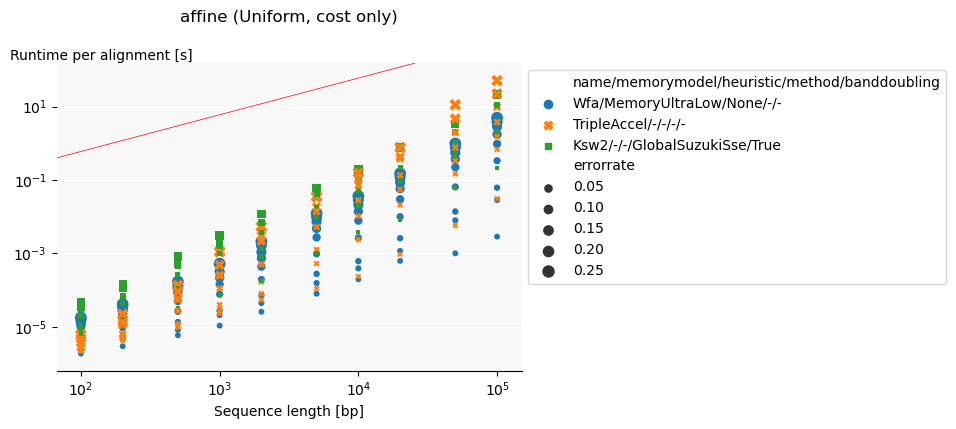

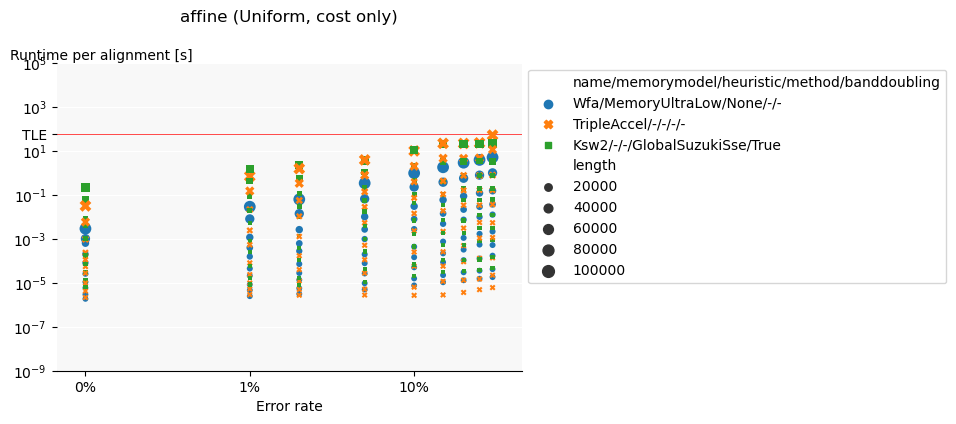

In [71]:
df = read_results("../results/affine.json")

df = df[df.job_traceback == False]
for k, g in df.groupby('job_dataset_Generated_errormodel'):
    plot(g, x='length', y='s_per_pair_capped', size='errorrate', name=f'affine ({k}, cost only)')
    plot(g, x='errorrate', y='s_per_pair_capped', size='length', name=f'affine ({k}, cost only)', xlog=True)

All values of pcorrect are nan.


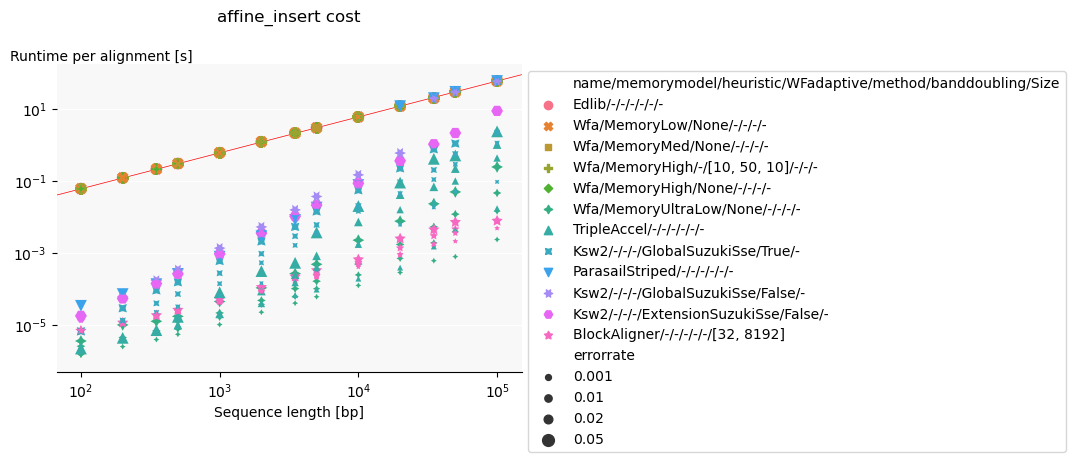

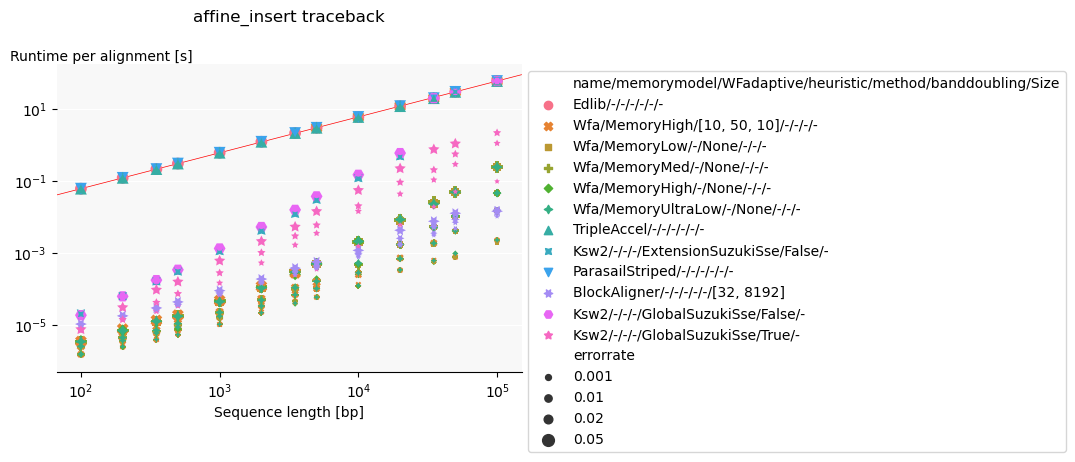

In [90]:
df = read_results("../results/affine_insert.json")

df = df[(df.job_costs_sub == 1) & (df.job_costs_open == 1) & (df.job_costs_extend == 1)]
df = df[df.job_dataset_Generated_errormodel == 'NoisyInsert']

plot_all(df, "affine_insert")

# Affine cost scaling

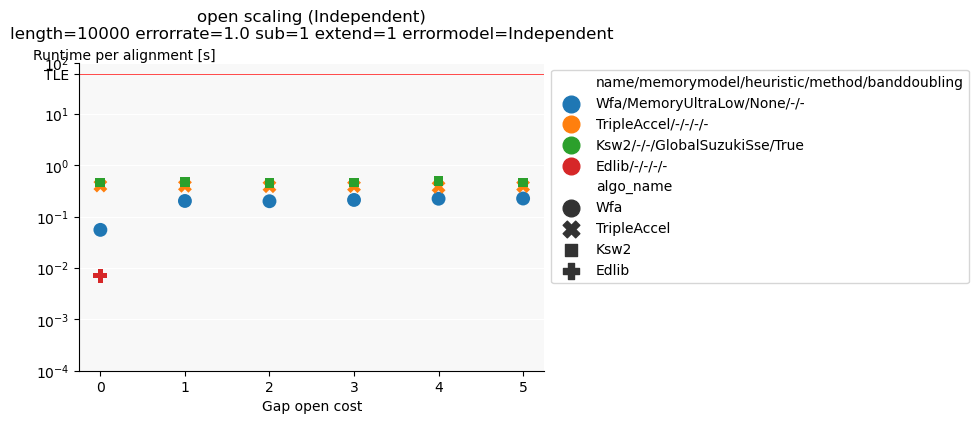

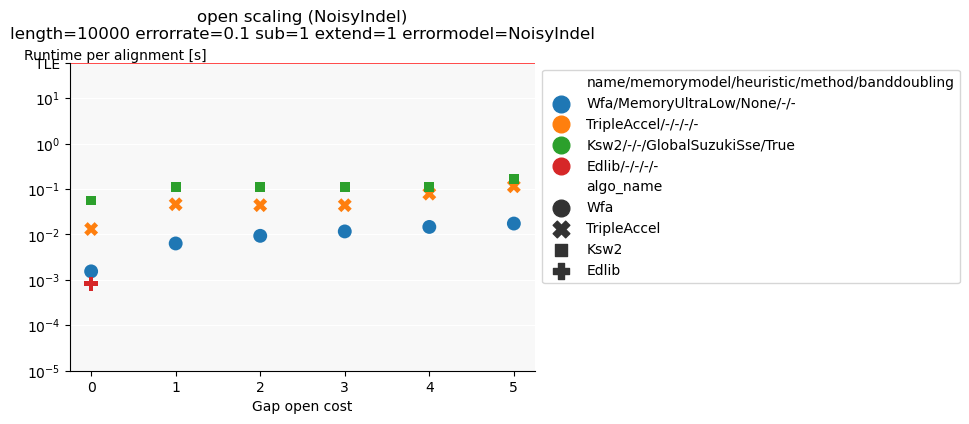

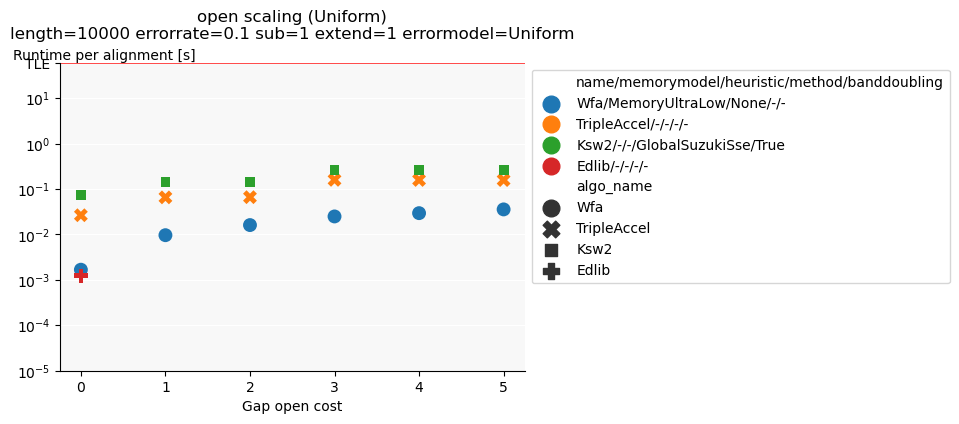

In [14]:
df = read_results("results/affine_cost_scaling.json")
df = df[(df.errorrate == 0.1) | (df.errorrate == 1.0)]
df = df[df.length == 10000]
# Ensure consistent styles
df = df.sort_values(by = 'algo_name', ascending=False)
g = df[(df.job_costs_sub == 1) & (df.job_costs_extend==1)]
for k, g in g.groupby('job_dataset_Generated_errormodel'):
    plot(g, x='job_costs_open', y='s_per_pair_capped', style='algo_name', name=f'open scaling ({k})', xlog=False, file=f'gap_open_scaling_{k}')
    
#g = df[(df.job_costs_open == 1) & (df.job_costs_extend==1)]
#for k, g in g.groupby('job_dataset_Generated_errormodel'):
#    plot(g, x='job_costs_sub', y='s_per_pair_capped', style='algo_name', name=f'sub scaling ({k})', xlog=False, )
    
#g = df[(df.job_costs_sub == df.job_costs_open) & (df.job_costs_extend==1)]
#for k, g in g.groupby('job_dataset_Generated_errormodel'):
#    plot(g, x='job_costs_sub', y='s_per_pair_capped', style='algo_name', name=f'sub+open scaling ({k})', xlog=False)
    
#g = df[(df.job_costs_sub == df.job_costs_open) & (df.job_costs_sub == df.job_costs_extend)]
#for k, g in g.groupby('job_dataset_Generated_errormodel'):
#    plot(g, x='job_costs_sub', y='s_per_pair_capped', style='algo_name', name=f'sub+open+extend scaling ({k})', xlog=False)
    
#g = df[(df.job_costs_sub == 5) & (df.job_costs_open == 5)]
#for k, g in g.groupby('job_dataset_Generated_errormodel'):
#    plot(g, x='job_costs_extend', y='s_per_pair_capped', style='algo_name', name=f'extend scaling ({k})', xlog=False)